# Selecting Highly Covered Genes

We want to exclude "poorly" covered genes from our anayses involving transcript coverege of the ribosome profiling data. Here we eventually obtain one set of genes that is "sufficiently" covered across the experiments of NSP1, NSP2 and WT.  

For an individual experiment, a gene is sufficiently covered if the following holds. The sum of the reads at the coding sequence of the region divided by the length of the coding sequence is one or larger. In other words, each nucleotide position has one or more reads, on average, on the coding sequence. 

Using the above difintion, first we determine the sufficiently covered genes for each experiment. Than, for each experiment group, we take the intersection of the sufficiently covered genes. For example, for the group NSP1, we intersect the three gene sets comve from the three replicates. After finding the intersections for the groups NSP1, NSP2 and WT, we take the unions of these sets. We use this union set for our downstream analysis coming from the coverage of CDS. Such analyses include pause sites and correlation.

## Observations

  1) Number of detected genes correlate with depth. For the same condition, we see strict set inclusion imposed by total number of reads.
  
  2) Different conditions influence the gene coverage. When we consider one experiment from each condition, we don't see a perfect set inclusion.  
  
  3) As a result of this selection process, we obtained 1493 genes.   
  
  4) For this set of 1493 genes, for each gene, we know that it is sufficiently covered in at least one experiment condition. For this condition, the gene is covered in all replicates.

In [1]:
import numpy as np
import pandas as pd
import math

import warnings
import scipy
import scipy.stats as stats
import scipy.stats as st
import matplotlib

from collections import OrderedDict

import ribopy
from ribopy.core.get_gadgets import get_region_boundaries
import h5py


from IPython.display import display_html

from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]


In [2]:
# Import the manuscript colors
import sys

sys.path.append('.')
from manuscript_colors import *

In [3]:
ribo_path = "../all.ribo"

def rename(x):
    return x.split("|")[4]

myribo = ribopy.Ribo(ribo_path, alias=rename)

COVERAGE_THRESHOLD = 1

In [4]:
myribo.print_info()

Ribo File Info:
---------------
Ribo File Version : 1.0
RiboPy Version    : 0.0.0
Creation Time     : 2020-07-20 23:53:05
Reference         : appris-v1
Min Read Length   : 15
Max Read Length   : 40
Metagene Radius   : 50
Left Span         : 35
Right Span        : 10

Experiments:
------------ 
Name                         Reads  Coverage  RNA-Seq  Metadata
20200618-NSP1-HEK-1        7075270         *        *          
20200618-NSP1-HEK-2        7954234         *        *          
20200618-NSP1-HEK-3        8631477         *        *          
20200618-NSP2-HEK-1        7319954         *        *          
20200618-NSP2-HEK-2       13871717         *        *          
20200618-NSP2-HEK-3        7436286         *        *          
20200717-NSP1-HEK-1-setB  12503413         *        *          
20200717-NSP1-HEK-2-setB  10390514         *        *          
20200717-NSP1-HEK-3-setB  16772718         *        *          
20200717-NSP2-HEK-1-setB  17989686         *        *          
2

In [5]:
NSP1_experiments = ["20200717-NSP1-HEK-1-setB", "20200717-NSP1-HEK-2-setB", "20200717-NSP1-HEK-3-setB"]
NSP2_experiments = ["20200717-NSP2-HEK-1-setB", "20200717-NSP2-HEK-2-setB", "20200717-NSP2-HEK-3-setB"]
WT_experiments   = ["20200717-WT-HEK-1-setB",   "20200717-WT-HEK-2-setB",  "20200717-WT-HEK-3-setB"]
EXPERIMENT_SET   = NSP1_experiments + NSP2_experiments + WT_experiments

In [6]:
def adjust_p_site_of_experiment(coverage_dict, offset):
    """
    coverage_dict is of the form
       transcript_name => coverage_vector
       
    offset is the number of nucleotides the coverage vector needs to be moved to the rigth
    
    """
    
    patch_vector = [0 for i in range(offset)]
    
    adjusted_coverage = dict()
    
    for transcript, coverage in coverage_dict.items():
        # append zeros to the elft end
        # remove equal numer of elements from the right end
        adjusted_coverage[transcript] = \
            np.concatenate(
                (patch_vector , coverage[: (-1)*offset ]) )
        
    return adjusted_coverage
        
        

def get_p_adjusted_coverage_dict(ribo, experiment, 
                                 range_lower, range_upper, 
                                 p_adj_offsets, 
                                 alias = True):
    
    tmp_dict = ribo.get_coverage(experiment  = experiment,
                                  range_lower = range_lower, 
                                  range_upper = range_lower,
                                  alias       = alias)
    
    coverage_dict = \
            adjust_p_site_of_experiment(\
                tmp_dict, p_adj_offsets[range_lower])
    
    # skip the first range as it is already taken care of
    for i in range(range_lower + 1, range_upper + 1):
        tmp_dict = ribo.get_coverage(experiment  = experiment,
                                     range_lower = i, 
                                     range_upper = i,
                                     alias       = alias)
        
        tmp_dict = adjust_p_site_of_experiment(
                            tmp_dict, 
                            p_adj_offsets[i])
        
        # Add the coverage values for each gene
        for gene in tmp_dict.keys():
            coverage_dict[gene] = \
                np.add( tmp_dict[gene], coverage_dict[gene] )
        
    
    return coverage_dict


##############################################################################################

def get_coverage(ribo, 
                 experiment,
                 range_lower   = 0,
                 range_upper   = 0,
                 alias         = False,
                 multiplier    = 1,
                 p_adj_offsets = None):
    """
    NOTETHAT THIS FUNCTION RETURNS A TUPLE!!!
    
    p_adjusted_offsets is a dictionary of the form
        read_length -> offset
    
    coverage_dict: This is the output of the function "get_coverage"
    of the ribo object.
    
    Returns a pair: (dataframe, coverage_dict)
    
    The coverage dictionary has the nucleotide coveraage of all the 
    transcripts
    
    In the dataframe, the last column 
    has the coverage density of a given transcript.
    The normalized covarage is defined by
       (#total_reads / #transcript_length) * 1000000
       
    """
    
    if p_adj_offsets:
        coverage_dict = get_p_adjusted_coverage_dict(
                             ribo          = ribo, 
                             experiment    = experiment, 
                             range_lower   = range_lower, 
                             range_upper   = range_upper, 
                             p_adj_offsets = p_adj_offsets, 
                             alias         = alias)
    else:    
        coverage_dict = ribo.get_coverage(experiment  = experiment,
                                          range_lower = range_lower, 
                                          range_upper = range_upper,
                                          alias       = alias)
    
    region_boundaries = get_region_boundaries(ribo._handle)
    
    transcript_names     = coverage_dict.keys()
    transcript_coverages = coverage_dict.values()
    transcript_total     = tuple( map( np.sum, transcript_coverages ) )
    transcript_lengths   = tuple( map(len, transcript_coverages) )
    normalized_coverage  = np.divide(transcript_total , transcript_lengths) * multiplier
    start_sites          = tuple( map( lambda x: x[1][0], region_boundaries ) )
    stop_sites           = tuple( map( lambda x: x[1][1], region_boundaries ) )
    
    # We also add normalized cds coverage
    cds_data = zip( start_sites, stop_sites, transcript_coverages )
    norm_cds = tuple( map( lambda x:  
                              (np.sum( x[2][x[0]:x[1]] ) / (x[1] - x[0]) )* multiplier,
                      cds_data) )
    
    result = pd.DataFrame(data = { "total"     :  transcript_total, 
                                   "length"    :  transcript_lengths,
                                   "cds_start" :  start_sites,
                                   "cds_stop"  :  stop_sites,
                                   "norm_cds"  :  norm_cds,
                                   "norm_cov"  :  normalized_coverage}, 
                          index = transcript_names) 
    
    return( (result, coverage_dict))

In [7]:
psite_offsets = { 28 : 12, 29:12, 30:12, 31:12,
                   32: 13, 33: 13, 34:13, 35: 13 }

In [8]:
# Definitions
coverage_min_length = 28
coverage_max_length = 35
this_alias          = rename

FIGURE_RESOLUTION = 600

# experiment -> (coverage_df, nucleotide coverage)
# where nucleodite coverage is a dictionary of the form
#       transcript -> coverage vector
coverages = { e: get_coverage(
                     ribo          = myribo, 
                     experiment    = e,
                     range_lower   = coverage_min_length,
                     range_upper   = coverage_max_length,
                     alias         = rename,
                     p_adj_offsets = psite_offsets )\
                 for e in myribo.experiments}

In [9]:
len(coverages["20200717-NSP1-HEK-2-setB"][0][ (coverages["20200717-NSP1-HEK-2-setB"][0].norm_cds>=COVERAGE_THRESHOLD ) ] )

1066

In [10]:
NSP1_sets = dict()

for e in NSP1_experiments:
    NSP1_sets[e] = set( coverages[e][0][ (coverages[e][0].norm_cds>=COVERAGE_THRESHOLD ) ].index)

In [11]:
pd.DataFrame( { 
               "#genes": [ len( NSP1_sets[e] ) for e in NSP1_experiments ],
               "depth": [ myribo.info["experiments"][e]["Reads"] for e in NSP1_experiments ] },
                index = NSP1_experiments)

,#genes,depth
20200717-NSP1-HEK-1-setB,1331,12503413
20200717-NSP1-HEK-2-setB,1066,10390514
20200717-NSP1-HEK-3-setB,1670,16772718


In [12]:
NSP1_intersection = NSP1_sets["20200717-NSP1-HEK-1-setB"].intersection(NSP1_sets["20200717-NSP1-HEK-2-setB"], NSP1_sets["20200717-NSP1-HEK-3-setB"])
len(NSP1_intersection)

1066

NSP1 Intersections

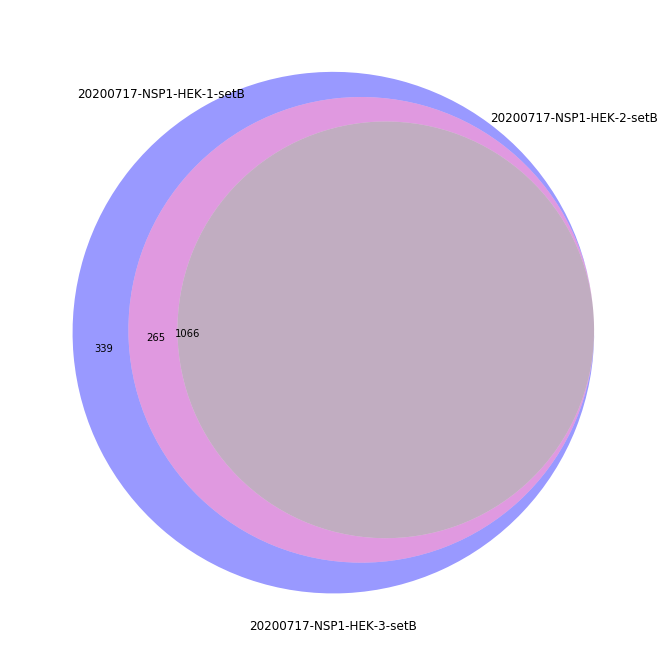

In [13]:
display_html("<center><b>NSP1 Intersections</b></center>", raw = True)

venn3(subsets = (NSP1_sets["20200717-NSP1-HEK-1-setB"], 
                 NSP1_sets["20200717-NSP1-HEK-2-setB"], 
                 NSP1_sets["20200717-NSP1-HEK-3-setB"]),
     set_labels = NSP1_experiments, normalize_to=0.5);

In [14]:
NSP2_sets = dict()

for e in NSP2_experiments:
    NSP2_sets[e] = set( coverages[e][0][ (coverages[e][0].norm_cds>=COVERAGE_THRESHOLD) ].index)

In [15]:
NSP2_intersection = NSP2_sets["20200717-NSP2-HEK-1-setB"].\
                      intersection(NSP2_sets["20200717-NSP2-HEK-2-setB"], NSP2_sets["20200717-NSP2-HEK-3-setB"])
len(NSP2_intersection)

1495

In [16]:
pd.DataFrame( { 
               "#genes": [ len( NSP2_sets[e] ) for e in NSP2_experiments ],
               "depth": [ myribo.info["experiments"][e]["Reads"] for e in NSP2_experiments ] },
                index = NSP2_experiments)

,#genes,depth
20200717-NSP2-HEK-1-setB,1939,17989686
20200717-NSP2-HEK-2-setB,1764,16564558
20200717-NSP2-HEK-3-setB,1495,13487211


NSP2 Intersections

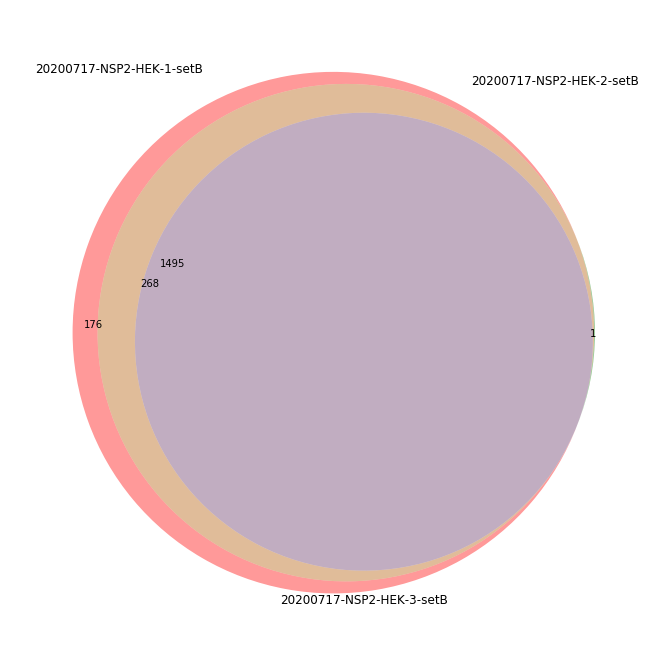

In [17]:
display_html("<center><b>NSP2 Intersections</b></center>", raw = True)

venn3(subsets = (NSP2_sets["20200717-NSP2-HEK-1-setB"], 
                 NSP2_sets["20200717-NSP2-HEK-2-setB"], 
                 NSP2_sets["20200717-NSP2-HEK-3-setB"]),
     set_labels = NSP2_experiments, normalize_to=0.5);

In [18]:
WT_sets = dict()

for e in WT_experiments:
    WT_sets[e] = set( coverages[e][0][ (coverages[e][0].norm_cds>=COVERAGE_THRESHOLD ) ].index)
    
WT_intersection = WT_sets[WT_experiments[0]].intersection( WT_sets[WT_experiments[1]], WT_sets[WT_experiments[2]] ) 
len(WT_intersection)

941

In [19]:
pd.DataFrame( { 
               "#genes": [ len( WT_sets[e] ) for e in WT_experiments ],
               "depth": [ myribo.info["experiments"][e]["Reads"] for e in WT_experiments ] },
                index = WT_experiments)

,#genes,depth
20200717-WT-HEK-1-setB,943,8527167
20200717-WT-HEK-2-setB,1992,17504702
20200717-WT-HEK-3-setB,1318,11440519


WT Intersections

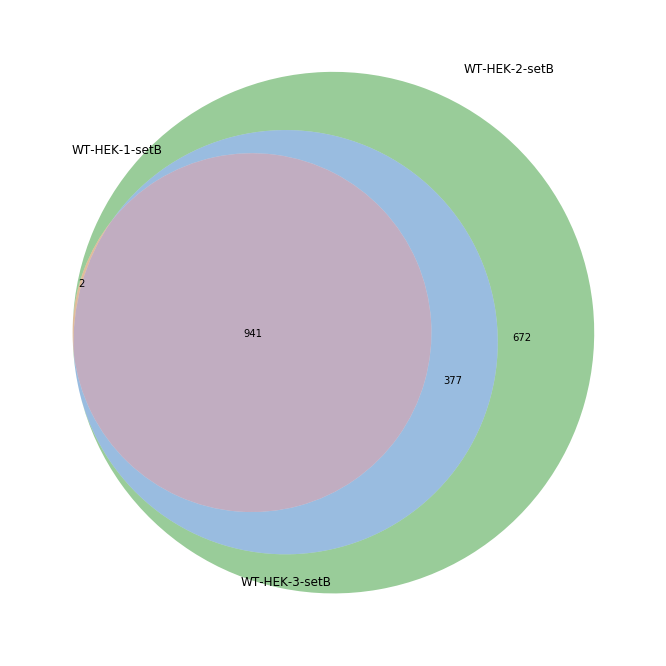

In [20]:
display_html("<center><b>WT Intersections</b></center>", raw = True)

venn3(subsets = (WT_sets[WT_experiments[0]], 
                 WT_sets[WT_experiments[1]], 
                 WT_sets[WT_experiments[2]]),
     set_labels = map(lambda x: x[9:], WT_experiments), normalize_to=0.5, ax = None);

# NSP1 , NSP2 and WT Intersections Together

NSP1, NSP2 and WT Intersections

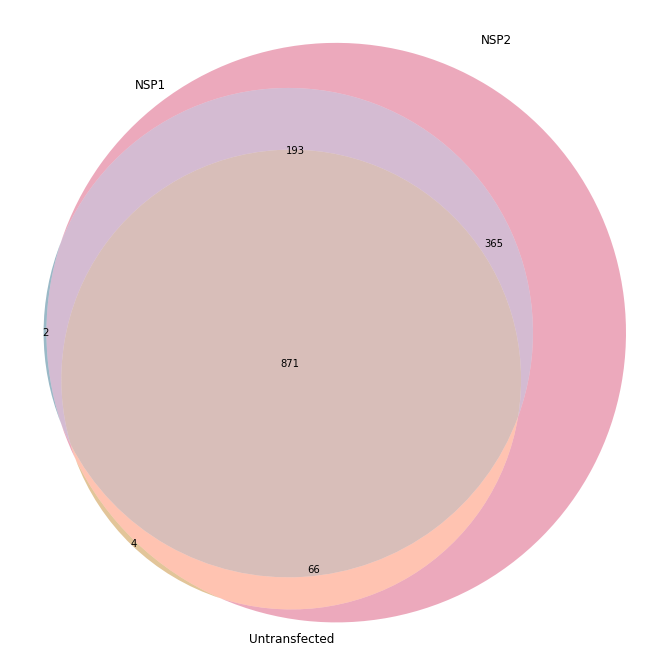

In [21]:
display_html("<center><b>NSP1, NSP2 and WT Intersections</b></center>", raw = True)

v = venn3( subsets=(NSP1_intersection, NSP2_intersection, WT_intersection),
       set_labels = ("NSP1", "NSP2", "Untransfected"),
       set_colors = (EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"],
                     EXPERIMENT_COLORS["20200717-NSP2-HEK-2-setB"],
                     EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]),
      normalize_to = 2);


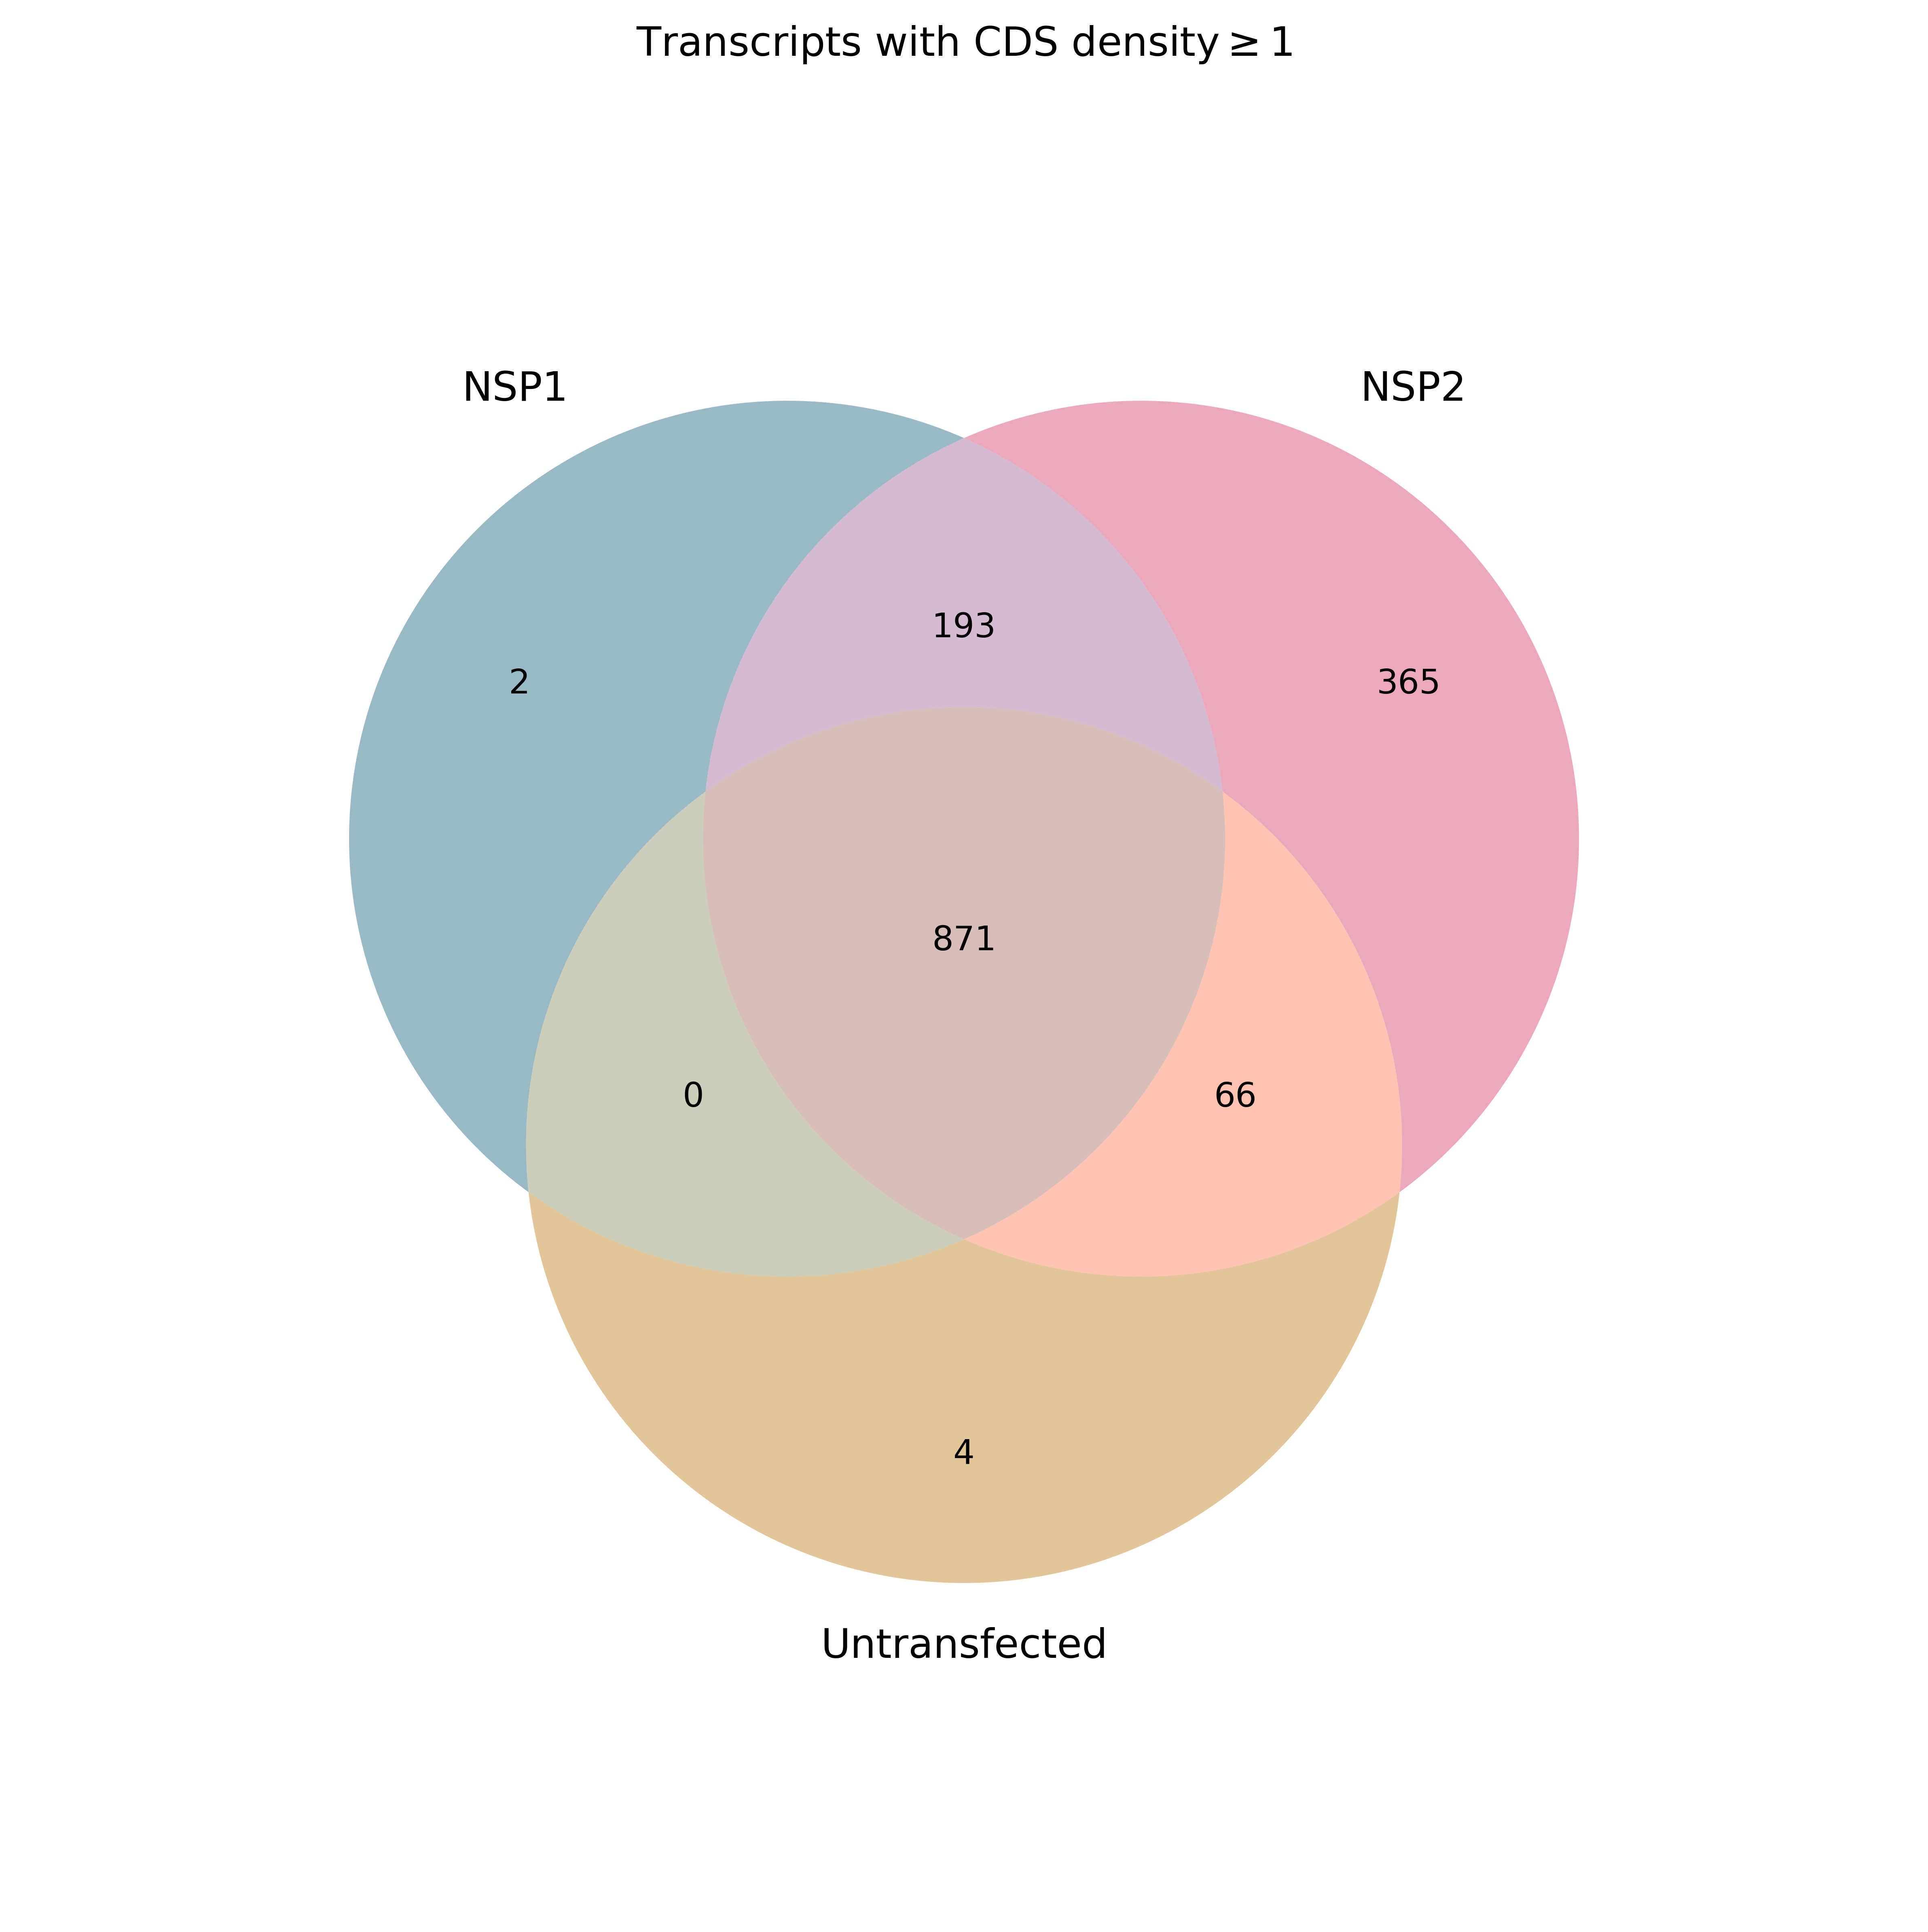

In [31]:
plt.figure( 1, (20,10),dpi = FIGURE_RESOLUTION )
#display_html("<center><b>Transcripts with CDS density $\ge 1$</b></center>", raw = True)

v = venn3( subsets=(1,1,1,1,1,1,1),
       set_labels = ("NSP1", "NSP2", "Untransfected"),
       set_colors = (EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"],
                     EXPERIMENT_COLORS["20200717-NSP2-HEK-2-setB"],
                     EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]),
      normalize_to = 0.1);

#v.get_patch_by_id('111').set_color('orange')
v.get_label_by_id('010').set_text('365')
v.get_label_by_id('110').set_text('193')
v.get_label_by_id('100').set_text('2')
v.get_label_by_id('001').set_text('4')
v.get_label_by_id('111').set_text('871')
v.get_label_by_id('101').set_text('0')
v.get_label_by_id('011').set_text('66')

plt.title("Transcripts with CDS density" + r'$\geq 1$')

plt.savefig("transcript_union_venn_padjusted.pdf")

NSP1, NSP2 and WT Intersections

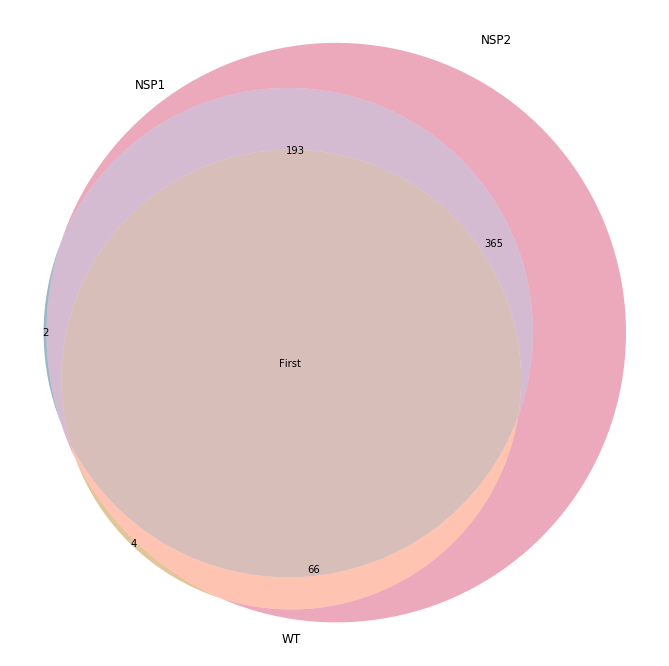

In [23]:
display_html("<center><b>NSP1, NSP2 and WT Intersections</b></center>", raw = True)

v = venn3( subsets=(NSP1_intersection, NSP2_intersection, WT_intersection),
       set_labels = ("NSP1", "NSP2", "WT"),
       set_colors = (EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"],
                     EXPERIMENT_COLORS["20200717-NSP2-HEK-2-setB"],
                     EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]),
      normalize_to = 2);

plt.savefig("venn_highly_covered_genes_p_adjusted.pdf");

#v.get_patch_by_id('111').set_color('orange')
v.get_label_by_id('111').set_text('First')
#a = v.get_patch_by_id('111')
#a.set_text("deneme")
#plt.show()

## Size of the Union

In [24]:
NSP1_total_reads = np.sum( [ myribo.info["experiments"][e]["Reads"] for e in NSP1_experiments ] )
NSP2_total_reads = np.sum( [ myribo.info["experiments"][e]["Reads"] for e in NSP2_experiments ] )
WT_total_reads   = np.sum( [ myribo.info["experiments"][e]["Reads"] for e in WT_experiments ] )

pd.DataFrame( { 
               "#genes": [ len(NSP1_intersection), len(NSP2_intersection), len(WT_intersection) ],
               "total depth" : [NSP1_total_reads, NSP2_total_reads, WT_total_reads]
               },
                index = ["NSP1", "NSP2", "WT"])

,#genes,total depth
NSP1,1066,39666645
NSP2,1495,48041455
WT,941,37472388


In [25]:
union_genes = NSP1_intersection.union(NSP2_intersection, WT_intersection)
len(union_genes)

1501

In [26]:
with open("highly_covered_genes.csv", "wt") as out_stream:
    for g in union_genes:
        print("{}".format(g), file = out_stream)

------------------------------------------

## Intersecting Individual Experiments From Different Sets

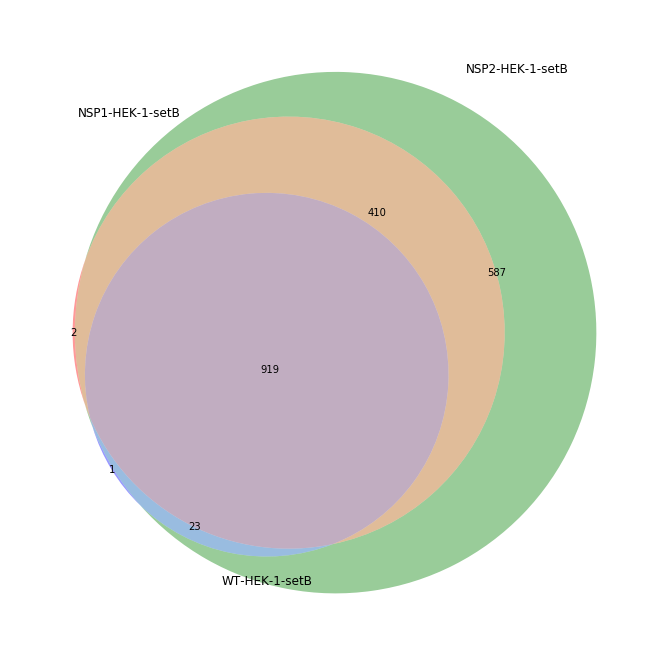

In [27]:
venn3(subsets = (NSP1_sets[NSP1_experiments[0]], 
                 NSP2_sets[NSP2_experiments[0]], 
                 WT_sets[WT_experiments[0]]),
     set_labels = map(lambda x: x[9:], (NSP1_experiments[0], NSP2_experiments[0], WT_experiments[0])
                     ), normalize_to=0.5, ax = None);

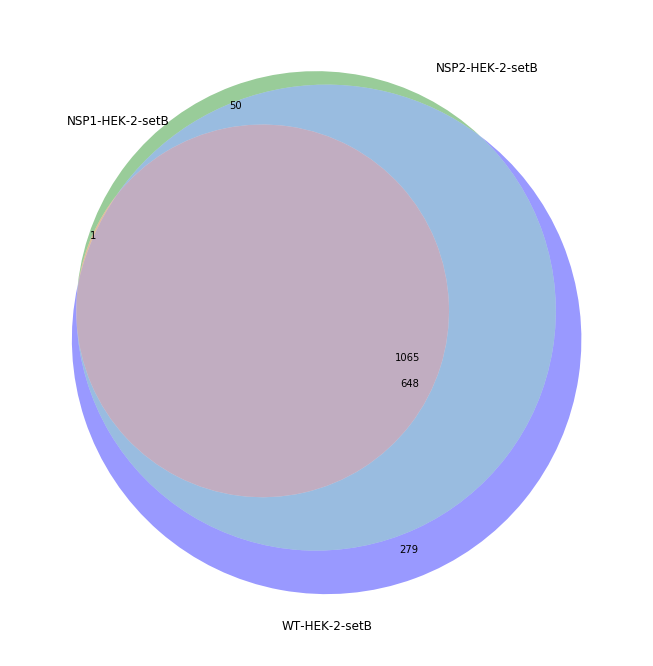

In [28]:
venn3(subsets = (NSP1_sets[NSP1_experiments[1]], 
                 NSP2_sets[NSP2_experiments[1]], 
                 WT_sets[WT_experiments[1]]),
     set_labels = map(lambda x: x[9:], (NSP1_experiments[1], NSP2_experiments[1], WT_experiments[1])
                     ), normalize_to=0.5, ax = None);

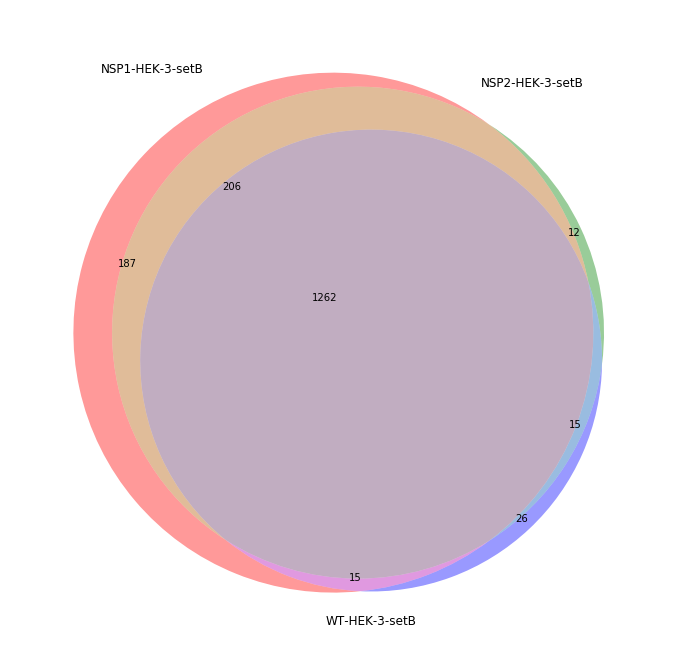

In [29]:
venn3(subsets = (NSP1_sets[NSP1_experiments[2]], 
                 NSP2_sets[NSP2_experiments[2]], 
                 WT_sets[WT_experiments[2]]),
     set_labels = map(lambda x: x[9:], (NSP1_experiments[2], NSP2_experiments[2], WT_experiments[2])
                     ), normalize_to=0.5, ax = None);